In [26]:
#Problem 1-----------------------------------------------------------------------------------------------------------------

#Import libraries

import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np

In [27]:
# (a)
boo = pd.read_csv("boo.csv")

# Less than 1% of rows have one or more missing values; drop them
print(f"Original rows: {len(boo)}")
boo_clean = boo.dropna()
print(f"Cleaned rows: {len(boo_clean)}")

X = boo_clean[['x1', 'x2', 'x3', 'x4', 'x5', 'x6']]
y = boo_clean['y']
X_with_intercept = sm.add_constant(X)  # Add a constant term to the model

model = sm.OLS(y, X_with_intercept).fit()
print(model.summary())


boo_fillednas = boo.fillna(boo.mean())
X_fillednas = boo_fillednas[['x1', 'x2', 'x3', 'x4', 'x5', 'x6']]
y_fillednas = boo_fillednas['y']
X_fillednas_with_intercept = sm.add_constant(X_fillednas)  # Add a cons tant term to the model

model_fillednas = sm.OLS(y_fillednas, X_fillednas_with_intercept).fit()
print(model_fillednas.summary())


Original rows: 5396
Cleaned rows: 5374
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     297.6
Date:                Wed, 30 Oct 2024   Prob (F-statistic):               0.00
Time:                        21:05:59   Log-Likelihood:                -7621.2
No. Observations:                5374   AIC:                         1.526e+04
Df Residuals:                    5367   BIC:                         1.530e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        

Text(0, 0.5, 'Density')

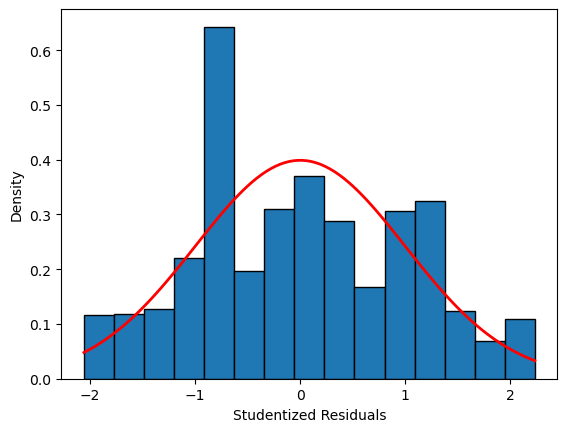

In [28]:
# (b)
# Get studentized residuals
influence = model.get_influence()
studentized_residuals = influence.resid_studentized_internal

# Generate points for the standard normal distribution
normdis_range = np.linspace(min(studentized_residuals), max(studentized_residuals), 100)
normdis = norm.pdf(normdis_range, 0, 1)

# Plot the standard normal density
plt.hist(studentized_residuals,density=True, label='Histogram of Studentized Residuals', bins=15, edgecolor='black')
plt.plot(normdis_range, normdis, 'r-', lw=2, label='Standard Normal Density')

plt.xlabel('Studentized Residuals')
plt.ylabel('Density')


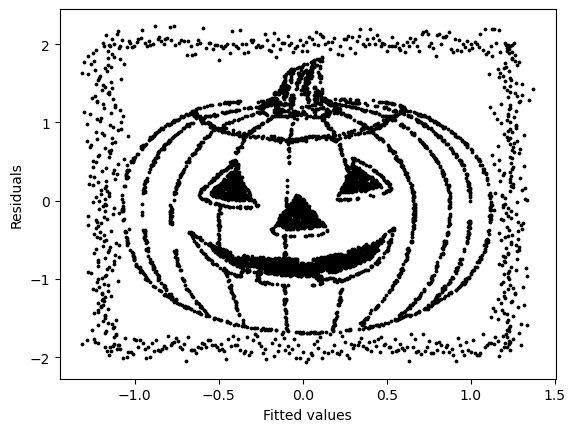

In [29]:
# (c)
fitted_values = model.fittedvalues
residuals = model.resid
plt.scatter(fitted_values, residuals, s=3, color='black')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()


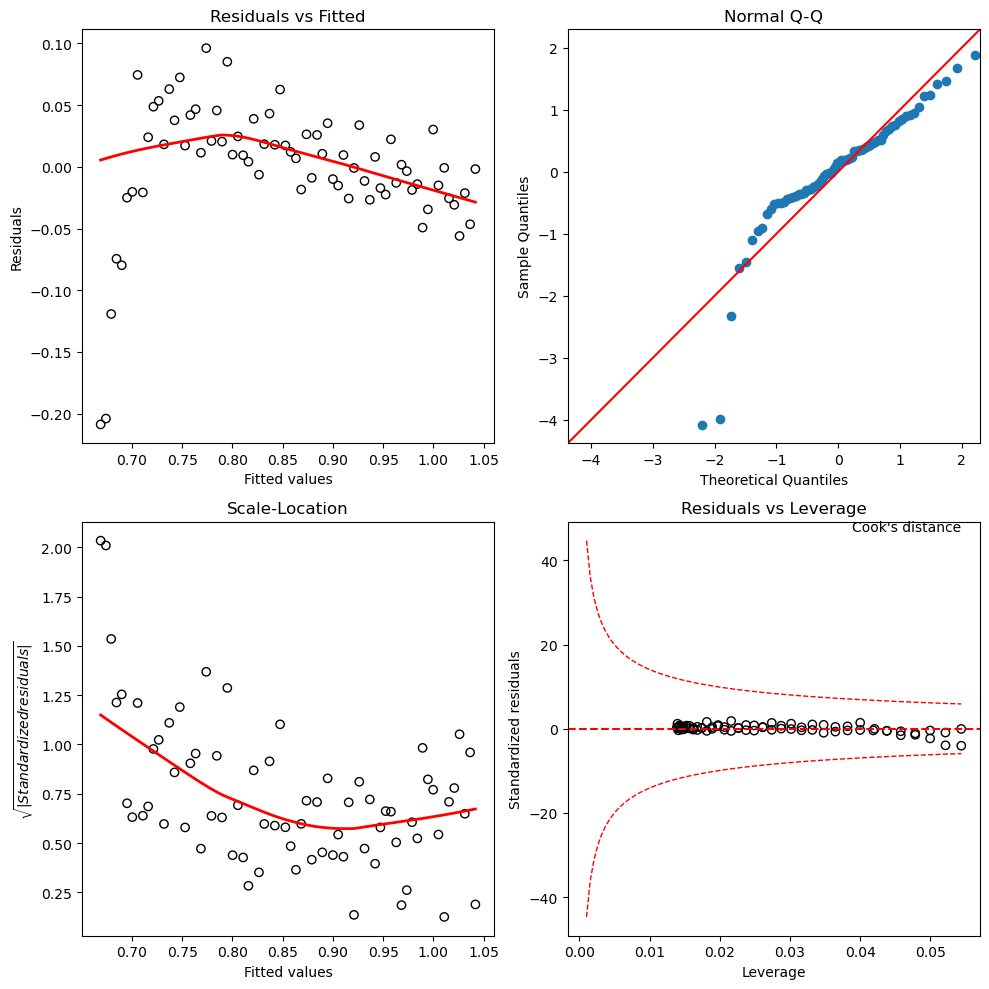

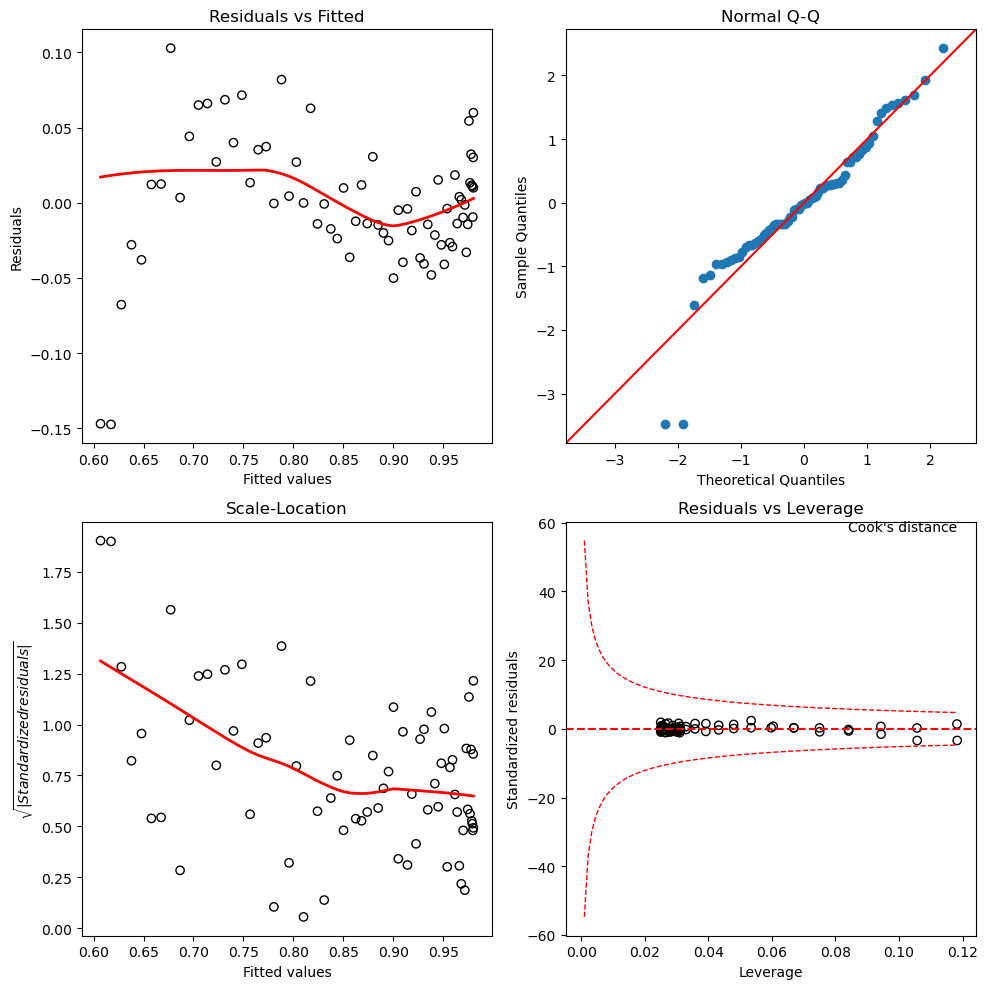

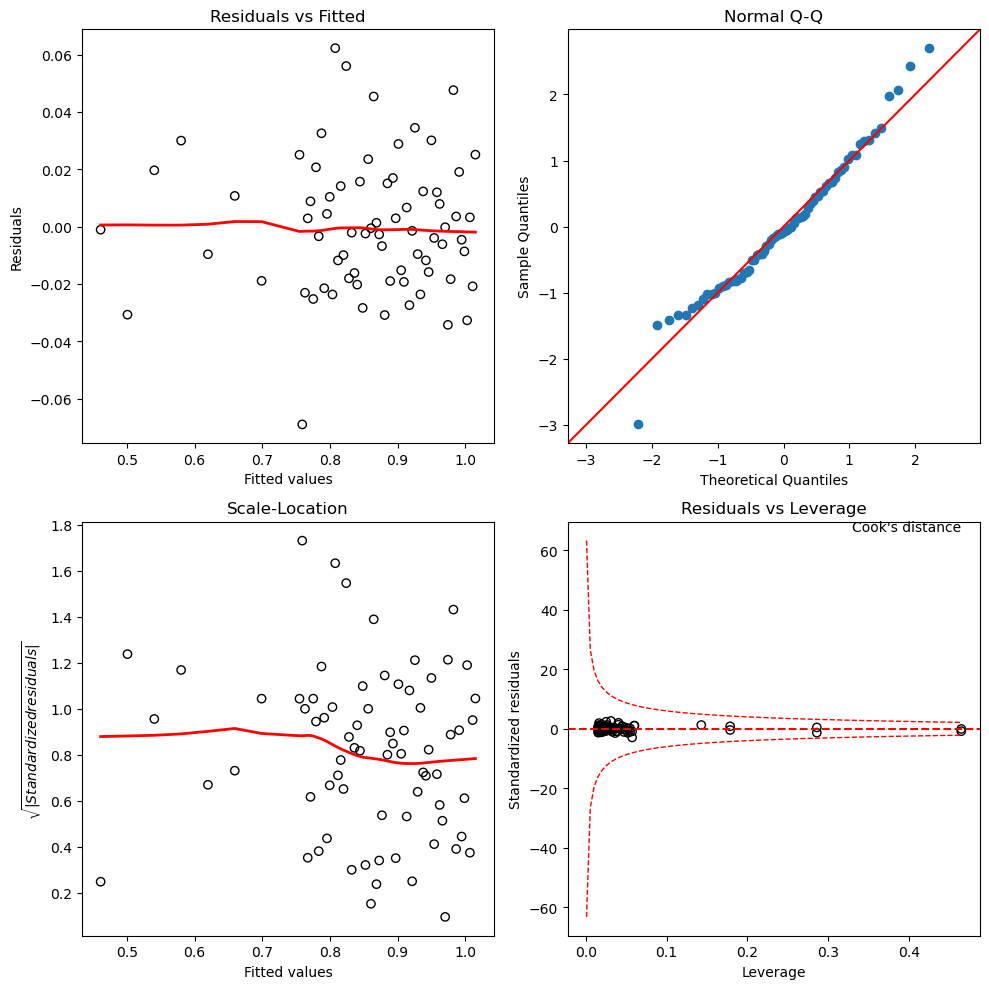

In [30]:
# Problem 2 ----------------------------------------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.nonparametric.smoothers_lowess import lowess

def plot_diagnostics(results, X, y):
    # Create influence instance
    influence = OLSInfluence(results)
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    
    # 1. Residuals vs Fitted
    axes[0, 0].scatter(results.fittedvalues, results.resid, edgecolors='k', facecolors='none')
    axes[0, 0].set_xlabel('Fitted values')
    axes[0, 0].set_ylabel('Residuals')
    axes[0, 0].set_title('Residuals vs Fitted')
    # Add smoothed line of fit
    smooth_resid = lowess(results.resid, results.fittedvalues)
    axes[0, 0].plot(smooth_resid[:, 0], smooth_resid[:, 1], color='r', lw=2)
    
    # 2. Normal Q-Q
    sm.qqplot(results.resid_pearson, line='45', fit=True, ax=axes[0, 1])
    axes[0, 1].set_title('Normal Q-Q')
    
    # 3. Scale-Location
    standardized_resid = results.get_influence().resid_studentized_internal
    axes[1, 0].scatter(results.fittedvalues, np.sqrt(np.abs(standardized_resid)), edgecolors='k', facecolors='none')
    axes[1, 0].set_xlabel('Fitted values')
    axes[1, 0].set_ylabel('$\\sqrt{|Standardized residuals|}$')
    axes[1, 0].set_title('Scale-Location')
    sqrt_abs_resid = np.sqrt(np.abs(standardized_resid))
    smooth = lowess(sqrt_abs_resid, results.fittedvalues)
    axes[1, 0].plot(smooth[:, 0], smooth[:, 1], color='r', lw=2)
    
     
    # 4. Residuals vs Leverage
    axes[1, 1].scatter(influence.hat_matrix_diag, results.resid_pearson, edgecolors='k', facecolors='none')
    axes[1, 1].set_xlabel('Leverage')
    axes[1, 1].set_ylabel('Standardized residuals')
    axes[1, 1].set_title('Residuals vs Leverage')
    axes[1, 1].axhline(y=0, color='r', linestyle='--')

    # Add Cook's distance contours
    cooksx = np.linspace(0.001, max(influence.hat_matrix_diag), 100)
    p = len(results.params)
    poscooks = np.sqrt((p * (1 - cooksx)) / cooksx)
    negcooks = -np.sqrt((p * (1 - cooksx)) / cooksx)

    axes[1, 1].plot(cooksx, poscooks, 'r--', lw=1)
    axes[1, 1].plot(cooksx, negcooks, 'r--', lw=1)

    # Add annotation for Cook's distance
    axes[1, 1].annotate("Cook's distance", xy=(max(cooksx), max(poscooks)), 
                        xytext=(0, 5), textcoords='offset points', 
                        ha='right', va='bottom')
    
    plt.tight_layout()
    plt.show()

nutrition = pd.read_csv('nutrition.csv')
# Display summary statistics
summary = nutrition.describe()


# Fit the SLR model using LinearRegression
X = nutrition['age'] # Predictor variable
y = nutrition['woh']  # Response variable
# Add a constant to the predictor variable (intercept term)
X_with_intercept = sm.add_constant(X)
X_with_intercept.rename(columns={'const': 'WOH_intercept'}, inplace=True)
# Create and fit the model
initial_model = sm.OLS(y, X_with_intercept).fit()

plot_diagnostics(initial_model, X_with_intercept, y)

# Create the new variable age^2
nutrition['age2'] = nutrition['age'] ** 2
# Define the new predictor variables including age and age^2
X_new = nutrition[['age', 'age2']]
# Add a constant to the predictor variables (intercept term)
X_new_with_intercept = sm.add_constant(X_new)
# Create and fit the MLR model using OLS
model_new = sm.OLS(y, X_new_with_intercept).fit()
plot_diagnostics(model_new, X_new_with_intercept, y)

# Using interaction terms (GROUP)
# nutrition is already sorted by age
nutrition['group'] = [1 if i < 7 else 0 for i in range(len(nutrition))] # group starts at 0
# Create interaction terms
nutrition['age_group'] = nutrition['age'] * nutrition['group']
# Define the new predictor variables including age, group, and the interaction term
X_with_interaction = nutrition[['age', 'group', 'age_group']]
# Add a constant to the predictor variables (intercept term)
X_interaction_with_intercept = sm.add_constant(X_with_interaction)
# Create and fit the interaction model using OLS
model_interaction = sm.OLS(y, X_interaction_with_intercept).fit()
# Call the function to plot the regression and residuals for the interaction model
plot_diagnostics(model_interaction, X_interaction_with_intercept, y)

In [31]:
#Problem 3 -----------------------------------------------------------------------------------------------------------------

#Import libraries

import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [32]:
#Load data set for problem 3 & display rows
cheese = pd.read_csv('cheese.csv')
print(cheese.head())  # Display first few rows

summary = cheese.describe() 
print(summary)

                  store     price    vol  disp
0   LOS ANGELES - LUCKY  2.578460  21374     1
1  LOS ANGELES - RALPHS  3.727867   6427     1
2    LOS ANGELES - VONS  2.711421  17302     1
3    CHICAGO - DOMINICK  2.651206  13561     1
4       CHICAGO - JEWEL  1.986674  42774     1
             price            vol         disp
count  5555.000000    5555.000000  5555.000000
mean      2.868823    4771.243744     0.645725
std       0.531717    5967.917635     0.478336
min       1.319907     231.000000     0.000000
25%       2.457262    1989.500000     0.000000
50%       2.703250    3408.000000     1.000000
75%       3.203279    5519.500000     1.000000
max       4.641757  148109.000000     1.000000


                            OLS Regression Results                            
Dep. Variable:                    vol   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     407.9
Date:                Wed, 30 Oct 2024   Prob (F-statistic):           1.40e-87
Time:                        21:06:03   Log-Likelihood:                -6449.2
No. Observations:                5555   AIC:                         1.290e+04
Df Residuals:                    5553   BIC:                         1.292e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
sales_intercept      7.8421      0.017  

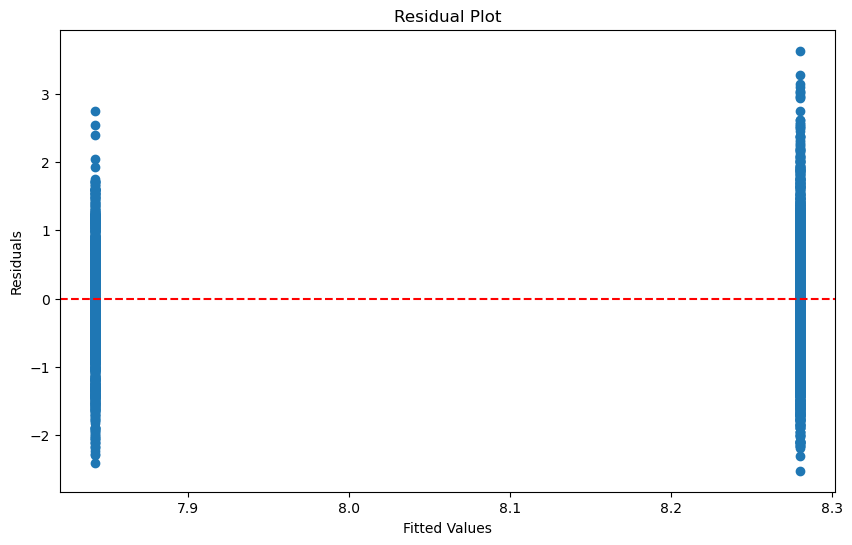

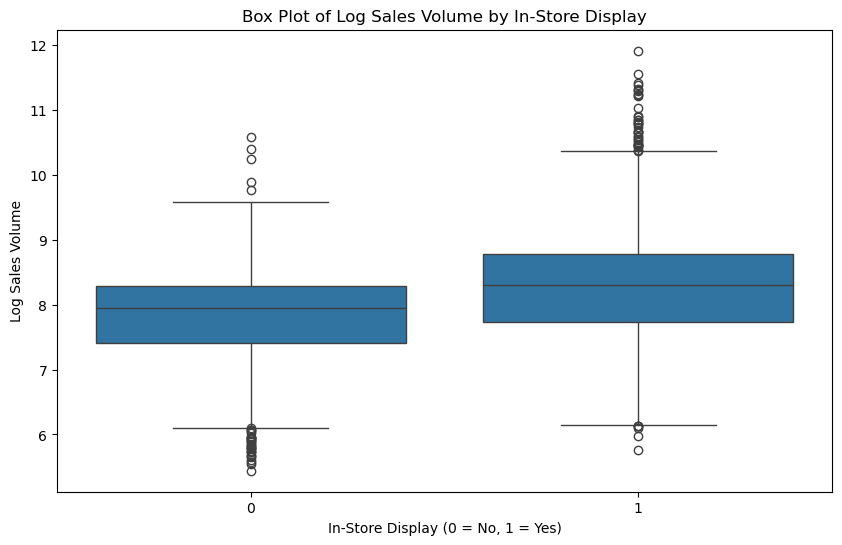

In [33]:
#Part A 
# Define predictor and response variables
display = cheese['disp']  # Predictor variable (in-store display)
sales = cheese['vol']     # Response variable (sales volume)
log_sales = np.log(sales) # Log-transformed sales volume

# Convert display to a categorical variable
display_category = display.astype('category')

# Add a constant to the predictor variable (intercept term)
X_with_intercept = sm.add_constant(display_category)
X_with_intercept.rename(columns={'const': 'sales_intercept', 'disp': 'display_in_store'}, inplace=True)

# Create and fit the model
model = sm.OLS(log_sales, X_with_intercept).fit()

# Print the summary of the model
print(model.summary())
# Plot residuals to check for patterns
plt.figure(figsize=(10, 6))
plt.scatter(model.fittedvalues, model.resid)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# Create a box plot to compare log sales for the two groups (with and without in-store displays)
plt.figure(figsize=(10, 6))
sns.boxplot(x=display, y=log_sales)
plt.xlabel('In-Store Display (0 = No, 1 = Yes)')
plt.ylabel('Log Sales Volume')
plt.title('Box Plot of Log Sales Volume by In-Store Display')
plt.show()

In [34]:
# Part b 
# Define predictor and response variables
display = cheese['disp']  # Predictor variable (in-store display)
sales = cheese['vol']     # Response variable (sales volume)
ln_sales = np.log(sales) # Log-transformed sales volume
price = cheese['price']
ln_price = np.log(price) # Log-transformed price


# Convert display to a categorical variable
display_category = display.astype('category')
price_display_interaction = display * ln_price

# New predictor variables
X = pd.DataFrame({
    'ln_price': ln_price,
    'display': display,
    'price_display_interaction': price_display_interaction
})

# Add a constant to the predictor variables (intercept term)
X_with_intercept = sm.add_constant(X)

# Create and fit the model
model = sm.OLS(log_sales, X_with_intercept).fit()

# Print the summary of the model to see the results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    vol   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.131
Method:                 Least Squares   F-statistic:                     279.9
Date:                Wed, 30 Oct 2024   Prob (F-statistic):          3.40e-169
Time:                        21:06:04   Log-Likelihood:                -6254.8
No. Observations:                5555   AIC:                         1.252e+04
Df Residuals:                    5551   BIC:                         1.254e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [38]:
#Problem 4-----------------------------------------------------------------------------------------------------------------

#Import libraries

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import os
from statsmodels.stats.diagnostic import het_breuschpagan, linear_rainbow
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import shapiro

In [ ]:
# Directory & Display Rows
stock_data = pd.read_csv("mfunds.csv")
print(stock_data.head())

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\DanielBunning\\Desktop\\Applied Regressions\\4. HW 4/mfunds.csv'

In [ ]:
# Part (a): Define variables, Find Excess Return, And Run Model
data = stock_data
windsor = data['windsor']
valmrkt = data['valmrkt']
tbill = data['tbill']

# Adjust returns by subtracting the risk-free rate
windsor_excess = windsor - tbill
valmrkt_excess = valmrkt - tbill

#Run CAPM Model
X = sm.add_constant(valmrkt_excess)  # Adding a constant for the intercept
y = windsor_excess
model = sm.OLS(y, X).fit()
print(model.summary())

In [ ]:
# Plotting diagnostic plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Residuals vs Fitted
sns.residplot(x=model.fittedvalues, y=model.resid, lowess=True, ax=axes[0, 0], line_kws={'color': 'red'})
axes[0, 0].set_title('Residuals vs Fitted')
axes[0, 0].set_xlabel('Fitted values')
axes[0, 0].set_ylabel('Residuals')

# QQ Plot
sm.qqplot(model.get_influence().resid_studentized_internal, line='45', ax=axes[0, 1])
axes[0, 1].set_title('Normal Q-Q')
axes[0, 1].set_ylabel('Standardized Residuals')

# Scale-Location Plot
sns.scatterplot(x=model.fittedvalues, y=np.sqrt(np.abs(model.get_influence().resid_studentized_internal)), ax=axes[1, 0])
axes[1, 0].set_title('Scale-Location')
axes[1, 0].set_xlabel('Fitted values')
axes[1, 0].set_ylabel('Sqrt(|Standardized Residuals|)')

# Residuals vs Leverage
sm.graphics.plot_leverage_resid2(model, ax=axes[1, 1])
axes[1, 1].set_title('Residuals vs Leverage')

plt.tight_layout()
plt.show()

In [ ]:
# Influence Plot to identify influential observations
fig, ax = plt.subplots(figsize=(10, 6))
sm.graphics.influence_plot(model, ax=ax, criterion="cooks")
ax.set_title('Influence Plot')
plt.tight_layout()
plt.show()

In [ ]:
# (c) Execute the Shapiro-Wilk test for normality
shapiro_test_stat, shapiro_p_value = shapiro(model.resid)
print(f"Shapiro-Wilk test statistic: {shapiro_test_stat}, p-value: {shapiro_p_value}")

if shapiro_p_value < 0.05:
    print("Reject the null hypothesis: Residuals are not normally distributed.")
else:
    print("Fail to reject the null hypothesis: Residuals are normally distributed.")

In [ ]:
# (d) Execute a test for heteroskedasticity (Breusch-Pagan test)
bp_test = het_breuschpagan(model.resid, X)
bp_p_value = bp_test[3]

print(f"Breusch-Pagan test p-value: {bp_p_value}")

if bp_p_value < 0.05:
    print("Reject the null hypothesis: There is heteroskedasticity.")
else:
    print("Fail to reject the null hypothesis: No evidence of heteroskedasticity.")

# Calculating robust standard errors
robust_model = model.get_robustcov_results()
print("Robust Standard Errors:")
print(robust_model.summary())

In [ ]:
# (e) Run the CAPM model on all other funds one-by-one
fund_columns = data.columns.drop(['valmrkt', 'tbill'])  # Assuming all other columns are funds
cooks_distances = {}

for fund in fund_columns:
    y_fund = data[fund] - tbill
    model_fund = sm.OLS(y_fund, X).fit()
    influence = model_fund.get_influence()
    cooks_d = influence.cooks_distance[0]
    max_cooks_idx = np.argmax(cooks_d)
    cooks_distances[fund] = (max_cooks_idx, cooks_d[max_cooks_idx])

    print(f"{fund}: Highest Cook's distance at index {max_cooks_idx} with value {cooks_d[max_cooks_idx]:.4f}")